In [1]:
import os
from os.path import join
import numpy as np
import pandas as pd
import cv2
import gc
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader, SubsetRandomSampler
import torchvision.transforms as T
import pytorch_lightning as pl 
from pytorch_lightning import LightningModule, LightningDataModule, Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.functional import accuracy
from torchsummaryX import summary
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

seed_everything(7)
USE_CUDA = torch.cuda.is_available() 
AVAIL_GPUS = min(1, torch.cuda.device_count())
device = torch.device('cuda:0' if USE_CUDA else 'cpu')

print('pytorch version :',torch.__version__)
print('Training device :',device)
print('cuda index :', torch.cuda.current_device())
print('graphic name :', torch.cuda.get_device_name())

Global seed set to 7


pytorch version : 1.9.0
Training device : cuda:0
cuda index : 0
graphic name : NVIDIA GeForce RTX 3080 Ti


# EDA

In [2]:
df = pd.read_pickle(r"C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI\TASK2\Week1\LSWMD.pkl")

In [3]:
def removebrackets(array):
    if array.shape == (1, 1):
        return "".join(array[0])
    elif array.shape == (0, 0):
        return None

In [4]:
df.rename(columns = {'trianTestLabel':'TrainTestLabel'}, inplace = 'True')
df['TrainTestLabel'] = df['TrainTestLabel'].apply(removebrackets)
df['failureType'] = df['failureType'].apply(removebrackets)

In [5]:
df = df.dropna()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172950 entries, 0 to 811454
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        172950 non-null  object 
 1   dieSize         172950 non-null  float64
 2   lotName         172950 non-null  object 
 3   waferIndex      172950 non-null  float64
 4   TrainTestLabel  172950 non-null  object 
 5   failureType     172950 non-null  object 
dtypes: float64(2), object(4)
memory usage: 9.2+ MB


In [7]:
df.isnull().sum()

waferMap          0
dieSize           0
lotName           0
waferIndex        0
TrainTestLabel    0
failureType       0
dtype: int64

In [8]:
df.head()

,waferMap,dieSize,lotName,waferIndex,TrainTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,Training,none
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,Training,none
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,Training,none
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,Training,none
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,Training,none


In [9]:
df.tail()

,waferMap,dieSize,lotName,waferIndex,TrainTestLabel,failureType
811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,21.0,Test,Edge-Loc
811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,22.0,Test,Edge-Loc
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,Test,Edge-Ring
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,Test,Edge-Loc
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,Test,Edge-Ring


### EDA 

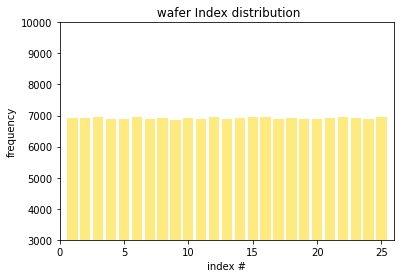

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline


uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='gold', align='center', alpha=0.5)
plt.title(" wafer Index distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(3000, 10000)
plt.show()
# 매우 균일한 분포를 보이므로, waferindex는 고려하지 않아도 됨.

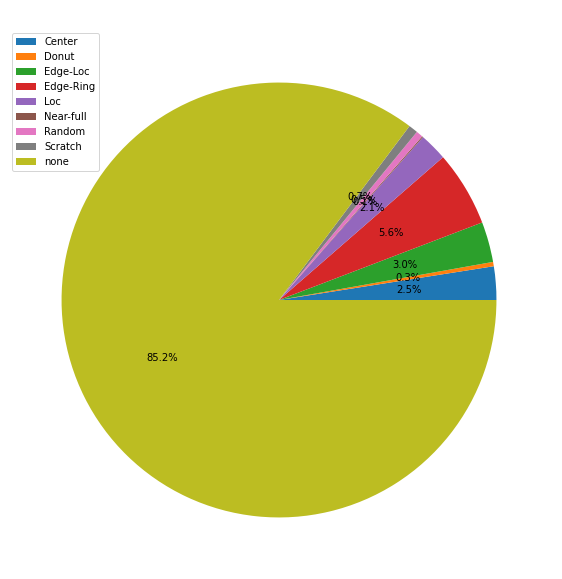

In [11]:
# failureType

plt.figure(figsize=(10, 10))
labels = np.unique(df.failureType, return_counts=True)[0]
counts = np.unique(df.failureType, return_counts=True)[1]

pie = plt.pie(x = counts, labels=labels, autopct = "%.1f%%")
_, texts, autotexts =pie
for items in texts:
    items.set_color('white') 
    items.set_fontsize('10')
for items in autotexts:
    items.set_fontsize('10')
plt.title('failureType', color = 'white', fontsize = 20)
plt.legend()
plt.show()

# Loc, Edge-loc에 비해 Near-full, Donut들의 인스턴스 개수가 매우 작음.

In [12]:
labels

array(['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full',
       'Random', 'Scratch', 'none'], dtype=object)

In [13]:
counts

array([  4294,    555,   5189,   9680,   3593,    149,    866,   1193,
       147431], dtype=int64)

# Preprocessing

In [14]:
df.failureType = df.failureType.map({
    'Center': 0,
    'Donut': 1,
    'Edge-Loc': 2,
    'Edge-Ring' : 3,
    'Loc': 4,
    'Near-full' : 5,
    'Random' : 6,
    'Scratch' : 7,
    "none" : 8
    })


In [15]:
df = df.drop(['waferIndex'], axis = 1)

In [16]:
print(np.unique(df.TrainTestLabel, return_counts=True)[0])
print(np.unique(df.TrainTestLabel, return_counts=True)[1])

['Test' 'Training']
[118595  54355]


In [17]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
    
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)
# waferMapDim 열 생성 

,waferMap,dieSize,lotName,TrainTestLabel,failureType,waferMapDim
144888,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3036.0,lot9334,Training,3,"(63, 62)"
719149,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1256.0,lot43795,Test,8,"(41, 40)"
736354,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",741.0,lot44493,Test,8,"(33, 29)"
776748,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",935.0,lot46133,Test,8,"(35, 34)"
658613,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",776.0,lot41100,Test,8,"(30, 34)"


In [18]:
heights = []
widths = []
for i in df.waferMapDim:
    heights.append(i[0])
    widths.append(i[1])

In [30]:
wfmap = df.iloc[10].waferMap
pd.DataFrame(wfmap)


,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,1,1,1,...,1,1,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,1,1,1,1,...,1,1,1,0,0,0,0,0,0,0
8,0,0,0,0,0,1,1,1,1,1,...,1,1,1,1,0,0,0,0,0,0
9,0,0,0,0,0,1,1,1,1,1,...,1,1,1,1,1,0,0,0,0,0


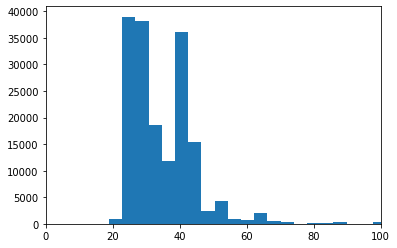

In [20]:
plt.hist(heights, bins=50)
plt.xlim(0,100)
plt.show()

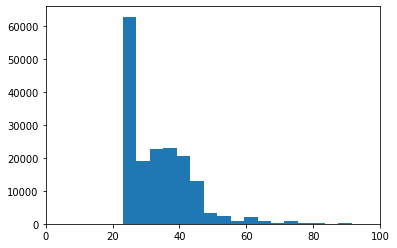

In [21]:
plt.hist(widths, bins=50)
plt.xlim(0,100)
plt.show()

In [22]:
df.iloc[1].waferMap[:,:,np.newaxis].shape

(45, 48, 1)

In [23]:
len(df)

172950

## Resize

In [31]:
label = np.empty((len(df),1), dtype=int)
W = torch.zeros((len(df), 128, 128))
transform = T.Resize((128, 128), interpolation=T.InterpolationMode.BICUBIC)
for i in tqdm(range(len(df))):
    wfmap = df.iloc[i].waferMap[np.newaxis,:,:]
    wfmap = torch.as_tensor(wfmap)
    resized = transform(wfmap)
    W[i] = resized
    label[i] = df.iloc[i].failureType
# About 1600iter/s

100%|██████████| 172950/172950 [01:41<00:00, 1702.58it/s]


In [ ]:
#### BAD WAY #####
'''
label = []
W = torch.zeros((1, 96, 96)).to(device)
transform = T.Resize((96, 96), interpolation=T.InterpolationMode.BICUBIC)

for i in tqdm(range(len(df))):
    wfmap = df.iloc[i].waferMap[np.newaxis,:,:]
    wfmap = torch.tensor(wfmap).to(device)
    resized = transform(wfmap)
    W = torch.vstack((W, resized))
    label.append(df.iloc[i].failureType)
    '''
# About 200iteration/s

In [43]:
# check dimension
W = np.array(W, dtype=np.uint8)
x = np.array(W, dtype=np.uint8)
x = x[:,np.newaxis,:,:]
y = np.array(label, dtype=np.uint8).reshape(-1, 1)

print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (172950, 1, 128, 128), y shape : (172950, 1)


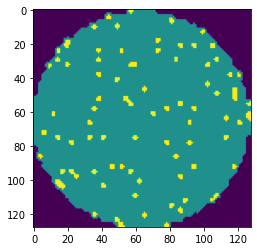

Faulty case : [8] 


In [45]:
# plot 1st data
plt.imshow(x[0][0])
plt.show()

# check faulty case
print('Faulty case : {} '.format(y[500]))

In [46]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

faulty_case_dict = {}
for i, f in enumerate(faulty_case) :
    print('{} : {}'.format(f, len(y[y==f]))) # y[y==f] : y에서 y==f인 행들만 뽑는다
    faulty_case_dict[i] = f

Faulty case list : [0 1 2 3 4 5 6 7 8]
0 : 4294
1 : 555
2 : 5189
3 : 9680
4 : 3593
5 : 149
6 : 866
7 : 1193
8 : 147431


In [ ]:
'''
# One-Hot Encoding
new_x = np.empty((len(x), 4, 128, 128),dtype=int)

for w in tqdm(range(len(x))):
    for i in range(128):
        for j in range(128):
            new_x[w, int(x[w, :, i, j]), i, j] = 1
            '''

# Convolutional Autoencoder for augmentation.
불균형 문제를 해결할 필요성을 확인함. <br>
이미지 데이터인 wafermap을 convolution AE를 활용해 해결시도

## 모델 구조

In [56]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encode1 = self.encoder_block(1, 16)
        self.encode2 = self.encoder_block(16, 32)
        self.encode3 = self.encoder_block(32, 64)
        self.encode4 = self.encoder_block(64, 128)
        self.encode5 = self.encoder_block(128, 256)
        self.maxpool = nn.MaxPool2d(kernel_size=2)

    def encoder_block(self, c_in, c_out):  # Conv2d - relu - batchnorm 수행 
        encode = nn.Sequential(
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(c_out)
        )
        return encode

    def forward(self, x):               # Encode x 3 -maxpool-encode-maxpool-encode      
        x = self.encode1(x)                   
        x = self.encode2(x)
        x = self.maxpool(x)
        x = self.encode3(x)
        x = self.encode4(x)
        x = self.maxpool(x)      
        x = self.encode5(x)                 
        return x 
BATCH_SIZE = 256
summary(Encoder(), torch.zeros(BATCH_SIZE, 1, 128, 128))

                              Kernel Shape         Output Shape    Params  \
Layer                                                                       
0_encode1.Conv2d_0           [1, 16, 3, 3]  [256, 16, 128, 128]     160.0   
1_encode1.ReLU_1                         -  [256, 16, 128, 128]         -   
2_encode1.BatchNorm2d_2               [16]  [256, 16, 128, 128]      32.0   
3_encode2.Conv2d_0          [16, 32, 3, 3]  [256, 32, 128, 128]     4.64k   
4_encode2.ReLU_1                         -  [256, 32, 128, 128]         -   
5_encode2.BatchNorm2d_2               [32]  [256, 32, 128, 128]      64.0   
6_maxpool                                -    [256, 32, 64, 64]         -   
7_encode3.Conv2d_0          [32, 64, 3, 3]    [256, 64, 64, 64]   18.496k   
8_encode3.ReLU_1                         -    [256, 64, 64, 64]         -   
9_encode3.BatchNorm2d_2               [64]    [256, 64, 64, 64]     128.0   
10_encode4.Conv2d_0        [64, 128, 3, 3]   [256, 128, 64, 64]   73.856k   

C:\Users\user\anaconda3\envs\torch180\lib\site-packages\torchsummaryX\torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_encode1.Conv2d_0,"[1, 16, 3, 3]","[256, 16, 128, 128]",160.0,2359296.0
1_encode1.ReLU_1,-,"[256, 16, 128, 128]",NaN,NaN
2_encode1.BatchNorm2d_2,[16],"[256, 16, 128, 128]",32.0,16.0
3_encode2.Conv2d_0,"[16, 32, 3, 3]","[256, 32, 128, 128]",4640.0,75497472.0
4_encode2.ReLU_1,-,"[256, 32, 128, 128]",NaN,NaN
5_encode2.BatchNorm2d_2,[32],"[256, 32, 128, 128]",64.0,32.0
6_maxpool,-,"[256, 32, 64, 64]",NaN,NaN
7_encode3.Conv2d_0,"[32, 64, 3, 3]","[256, 64, 64, 64]",18496.0,75497472.0
8_encode3.ReLU_1,-,"[256, 64, 64, 64]",NaN,NaN


In [57]:
# Upsampling할때 Conv2d로 업샘플링하는거 실패.
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decode1 = self.decoder_block(256, 128)             
        self.decode2 = self.decoder_block(128, 64, stride=2, output_padding=1)  # Upsample
        self.decode3 = self.decoder_block(64, 32)
        self.decode4 = self.decoder_block(32, 16, stride=2, output_padding=1)   # Upsample
        self.decode5 = self.decoder_block(16, 1)              
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.upsample_bicubic = nn.Upsample(scale_factor=2, mode='bicubic', align_corners=True)

    def decoder_block(self, c_in, c_out, stride=1, padding=1, output_padding=0):             
        decode = nn.Sequential(
            nn.ConvTranspose2d(
                c_in, c_out, kernel_size=3, stride=stride, 
                padding=padding, output_padding=output_padding
                ), # ConvTR2d - relu - batchnorm 수행, stride가 주어질 경우 upsample, output에 padding 추가
            nn.ReLU(),
            nn.BatchNorm2d(c_out), 
        )
        return decode

    def forward(self, x):
        x = self.decode1(x)           
        x = self.decode2(x)
        x = self.decode3(x)
        x = self.decode4(x)
        x = self.decode5(x) 
        return x
        
summary(Decoder(), torch.zeros(BATCH_SIZE, 256, 32, 32))

                                  Kernel Shape         Output Shape   Params  \
Layer                                                                          
0_decode1.ConvTranspose2d_0   [128, 256, 3, 3]   [256, 128, 32, 32]  295.04k   
1_decode1.ReLU_1                             -   [256, 128, 32, 32]        -   
2_decode1.BatchNorm2d_2                  [128]   [256, 128, 32, 32]    256.0   
3_decode2.ConvTranspose2d_0    [64, 128, 3, 3]    [256, 64, 64, 64]  73.792k   
4_decode2.ReLU_1                             -    [256, 64, 64, 64]        -   
5_decode2.BatchNorm2d_2                   [64]    [256, 64, 64, 64]    128.0   
6_decode3.ConvTranspose2d_0     [32, 64, 3, 3]    [256, 32, 64, 64]  18.464k   
7_decode3.ReLU_1                             -    [256, 32, 64, 64]        -   
8_decode3.BatchNorm2d_2                   [32]    [256, 32, 64, 64]     64.0   
9_decode4.ConvTranspose2d_0     [16, 32, 3, 3]  [256, 16, 128, 128]   4.624k   
10_decode4.ReLU_1                       

C:\Users\user\anaconda3\envs\torch180\lib\site-packages\torchsummaryX\torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_decode1.ConvTranspose2d_0,"[128, 256, 3, 3]","[256, 128, 32, 32]",295040.0,301989888.0
1_decode1.ReLU_1,-,"[256, 128, 32, 32]",NaN,NaN
2_decode1.BatchNorm2d_2,[128],"[256, 128, 32, 32]",256.0,128.0
3_decode2.ConvTranspose2d_0,"[64, 128, 3, 3]","[256, 64, 64, 64]",73792.0,301989888.0
4_decode2.ReLU_1,-,"[256, 64, 64, 64]",NaN,NaN
5_decode2.BatchNorm2d_2,[64],"[256, 64, 64, 64]",128.0,64.0
6_decode3.ConvTranspose2d_0,"[32, 64, 3, 3]","[256, 32, 64, 64]",18464.0,75497472.0
7_decode3.ReLU_1,-,"[256, 32, 64, 64]",NaN,NaN
8_decode3.BatchNorm2d_2,[32],"[256, 32, 64, 64]",64.0,32.0


# AutoEncoder Train

## Train step For AE

In [58]:
def AE_train(loader, epoch):
    running_loss = 0.0
    num_correct = 0
    num_samples = len(loader.dataset)
    batch_cnt = int(num_samples/BATCH_SIZE)
    encoder.to(device)
    decoder.to(device)
    encoder.train()
    decoder.train()

    for batch_idx, (X, _) in enumerate(tqdm(loader)):
        X = X.to(device).float()
        optimizer.zero_grad()
        # 순전파 
        encoded = encoder(X)
        decoded = decoder(encoded)
        loss = criterion(decoded, X)
        # 역전파 
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        train_loss = running_loss/batch_cnt

        if batch_idx % batch_cnt == batch_cnt-1:
            writer.add_scalar('train_loss', train_loss, epoch)
            print("EPOCH {} train_loss : {:.5f}".format(epoch, train_loss))
            running_loss = 0.0
            
def AE_validate(loader, epoch):
    print("working on val set...")
    num_correct = 0
    num_samples = len(loader.dataset)
    val_loss = []
    encoder.eval()  # set model to evaluation mode
    decoder.eval()
    with torch.no_grad():
        for X, _ in loader:
            X = X.to(device).float()  # move to device, e.g. GPU
            encoded = encoder(X)
            decoded = decoder(encoded)
            val_loss.append(criterion(decoded, X).item())

        val_loss = torch.mean(torch.tensor(val_loss)).item()
        
        scheduler.step(val_loss) # val_loss가 개선되지 않으면 lr scheduler 실행
        writer.add_scalar('val_loss', val_loss, epoch)
        print("EPOCH {} val_loss : {:.5f}".format(epoch, val_loss))


In [66]:
# Convert to Tensor
x = torch.as_tensor(x, dtype=torch.int8)
y = torch.as_tensor(y, dtype=torch.int8)
print('X shape : {}, y shape : {}'.format(x.shape, y.shape))

X shape : torch.Size([172950, 1, 128, 128]), y shape : torch.Size([172950, 1])


In [67]:
encoder = Encoder()
decoder = Decoder()
dataset = TensorDataset(x, y)
train_indices, val_indices = train_test_split(list(range(len(y))), test_size=0.2, stratify=y)

train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

sample = next(iter(train_loader))
print(sample[0].shape)
print(sample[1].shape)

torch.Size([256, 1, 128, 128])
torch.Size([256, 1])


In [68]:
# Tensorboard에 로그 기록 
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

# parameter
BATCH_SIZE = 256
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

# 인코더와 디코더의 parameter를 묶어 동시에 학습.
parameters = list(encoder.parameters()) + list(decoder.parameters())
criterion = nn.MSELoss()
optimizer = optim.Adam(parameters, lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode='min',
                factor=0.5,
                patience=2, 
                threshold=0.05,
                threshold_mode='rel',
                cooldown=0, 
                verbose=True
            )

In [80]:
# if CUDA out of memory
'''
import gc
del encoder
del decoder
del train_loader
del val_loader
gc.collect()
torch.cuda.empty_cache()
'''

In [62]:
for epoch in range(NUM_EPOCHS):
    AE_train(train_loader, epoch)
    AE_validate(val_loader, epoch)

100%|██████████| 541/541 [02:37<00:00,  3.43it/s]

EPOCH 0 train_loss : 0.51082
working on val set...


EPOCH 0 val_loss : 0.18014


100%|██████████| 541/541 [02:41<00:00,  3.36it/s]

EPOCH 1 train_loss : 0.07965
working on val set...


EPOCH 1 val_loss : 0.02068


100%|██████████| 541/541 [02:37<00:00,  3.44it/s]

EPOCH 2 train_loss : 0.00857
working on val set...


EPOCH 2 val_loss : 0.00314


100%|██████████| 541/541 [02:38<00:00,  3.42it/s]

EPOCH 3 train_loss : 0.00152
working on val set...


EPOCH 3 val_loss : 0.00193


100%|██████████| 541/541 [02:40<00:00,  3.38it/s]

EPOCH 4 train_loss : 0.00092
working on val set...


EPOCH 4 val_loss : 0.00152


100%|██████████| 541/541 [02:36<00:00,  3.45it/s]

EPOCH 5 train_loss : 0.00068
working on val set...


EPOCH 5 val_loss : 0.00120


100%|██████████| 541/541 [02:38<00:00,  3.41it/s]

EPOCH 6 train_loss : 0.00054
working on val set...


EPOCH 6 val_loss : 0.00092


100%|██████████| 541/541 [02:37<00:00,  3.43it/s]

EPOCH 7 train_loss : 0.00043
working on val set...


EPOCH 7 val_loss : 0.00073


100%|██████████| 541/541 [02:38<00:00,  3.41it/s]

EPOCH 8 train_loss : 0.00035
working on val set...


EPOCH 8 val_loss : 0.00059


100%|██████████| 541/541 [02:37<00:00,  3.44it/s]

EPOCH 9 train_loss : 0.00029
working on val set...


EPOCH 9 val_loss : 0.00046


In [63]:
# CUDA 메모리 정리 
encoder.to('cpu')
decoder.to('cpu')
gc.collect()
torch.cuda.empty_cache() 

In [65]:
# Encode original faulty wafer
x_sample = next(iter(train_loader))[0]
encoded_x = encoder(x_sample)
encoded_x.shape

RuntimeError: expected scalar type Char but found Float

In [88]:
# Add noise to encoded latent faulty wafers vector.
noised_encoded_x = encoded_x + torch.normal(mean=torch.zeros((len(encoded_x), 256, 32, 32)), std=0.3*torch.ones((len(encoded_x), 256, 32, 32)))

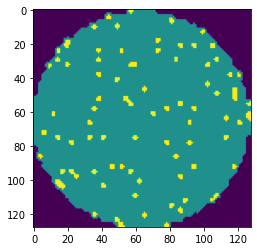

In [89]:
# check original faulty wafer data
plt.imshow(np.argmax(X[0], axis=0)) ## argmax : 차원에 대해서 (지금은 channel) 최댓값, 생성되는 이미지 픽셀값

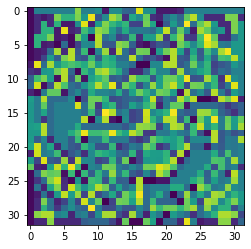

In [90]:
# original encoded data
plt.imshow(torch.argmax(encoded_x[0], axis = 0))

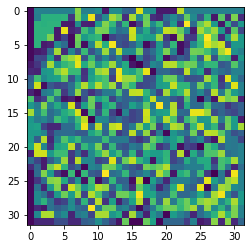

In [91]:
# noised encoded data
plt.imshow(torch.argmax(noised_encoded_x[0], axis=0))

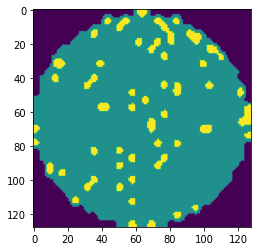

In [92]:
# check reconstructed original faulty wafer data
plt.imshow(torch.argmax(decoder(encoded_x)[0], axis=0))

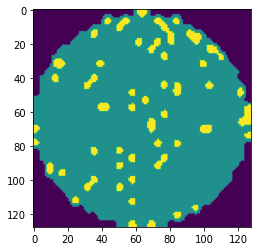

In [93]:
# check reconstructed noised faulty wafer data
plt.imshow(torch.argmax(decoder(noised_encoded_x)[0], axis=0))

## Data augmentation


In [94]:
print(X.shape)
print(noised_encoded_x.shape)
print(decoder(noised_encoded_x).shape)

torch.Size([172950, 4, 128, 128])
torch.Size([256, 256, 32, 32])
torch.Size([256, 4, 128, 128])


In [100]:
# augment function define
STD = 0.3
def gen_data(x, label):
    # Encode input x
    encoded_x = encoder(x)
    # dummy array for collecting noised x
    gen_x = np.empty((len(x), 4, 128, 128))
    
    # Make x until total # of x to 5000
    for i in range((5000//len(x)) + 1):
        noised_encoded_x = encoded_x + np.normal(mean=np.zeros((len(encoded_x), 256, 13, 13)), std= STD*np.ones((len(encoded_x), 256, 13, 13)))
        noised_gen_x = decoder(noised_encoded_x)
        gen_x[i] = noised_gen_x
    gen_y = np.full((len(gen_x), 1), label)
    
    return gen_x[1:], gen_y[1:]

In [120]:
# reset
X = train_loader 
y = np.array(label).reshape((-1, 1))
y = torch.as_tensor(y)
print(X.shape)
print(y.shape)

AttributeError: 'DataLoader' object has no attribute 'shape'

In [118]:
# Augmentation for all faulty case.
new_x = torch.empty((len(X), 9, 4, 128, 128))

for f in tqdm(faulty_case) : 
    if f == 8 : # skip none case
        continue
    target_index = np.where(y==f)[0]
    gen_x, gen_y = gen_data(X[target_index], f)
    new_x = torch.cat((new_x, gen_x), axis=0)
    y = torch.cat((y, gen_y))

NameError: name 'X' is not defined

In [ ]:
print('After Generate X shape : {}, y shape : {}'.format(X.shape, y.shape))

After Generate X shape : torch.Size([30707, 3, 26, 26]), y shape : torch.Size([30707, 1])


In [ ]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

0 : 2160
1 : 2002
2 : 2368
3 : 2046
4 : 2376
5 : 2032
6 : 2146
7 : 2088
8 : 13489


In [ ]:
# choice index without replace.
none_idx = np.where(y==8)[0][np.random.choice(len(np.where(y==8)[0]), size=11000, replace=False)]

In [ ]:
X = X.detach().numpy()
y = y.detach().numpy()

In [ ]:
# delete choiced index data.
new_x = np.delete(X, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

In [ ]:
print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))

After Delete "none" class new_x shape : (19707, 3, 26, 26), new_y shape : (19707, 1)


In [ ]:
for f in faulty_case :
    print('{} : {}'.format(f, len(new_y[new_y==f])))

0 : 2160
1 : 2002
2 : 2368
3 : 2046
4 : 2376
5 : 2032
6 : 2146
7 : 2088
8 : 2489


In [ ]:
new_x = torch.tensor(new_x, dtype=torch.float32)
new_y = torch.tensor(new_y, dtype=torch.long)
dataset = TensorDataset(new_x, new_y)
train_indices, val_indices = train_test_split(list(range(len(new_y))), test_size = 0.2, stratify = new_y)

train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

sample = next(iter(train_loader))
print(sample[0].shape)
print(sample[1].shape)

torch.Size([1024, 3, 26, 26])
torch.Size([1024, 1])


### 모델 생성

# Transfer Learning

In [ ]:
from efficientnet_pytorch import EfficientNet 
model = EfficientNet.from_pretrained("efficientnet-b4", advprop=True, num_classes = 9) # Transfer learning
summary(model, torch.zeros(BATCH_SIZE, 3, 26, 26))

Loaded pretrained weights for efficientnet-b4


RuntimeError: Calculated padded input size per channel: (4 x 4). Kernel size: (5 x 5). Kernel size can't be greater than actual input size

In [ ]:
# Make keras model to sklearn classifier.
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=1024, verbose=2) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
print('Class Activation Map Cross validation score : {:.4f}'.format(np.mean(results)))

Epoch 1/10
9/9 - 3s - loss: 2.2852 - accuracy: 0.2343
Epoch 2/10
9/9 - 1s - loss: 1.0510 - accuracy: 0.6105
Epoch 3/10
9/9 - 1s - loss: 0.5976 - accuracy: 0.7974
Epoch 4/10
9/9 - 1s - loss: 0.3421 - accuracy: 0.8905
Epoch 5/10
9/9 - 1s - loss: 0.2021 - accuracy: 0.9400
Epoch 6/10
9/9 - 1s - loss: 0.1012 - accuracy: 0.9739
Epoch 7/10
9/9 - 1s - loss: 0.0647 - accuracy: 0.9824
Epoch 8/10
9/9 - 1s - loss: 0.0456 - accuracy: 0.9894
Epoch 9/10
9/9 - 1s - loss: 0.0371 - accuracy: 0.9903
Epoch 10/10
9/9 - 1s - loss: 0.0242 - accuracy: 0.9948
5/5 - 0s - loss: 0.0564 - accuracy: 0.9839
Epoch 1/10
9/9 - 1s - loss: 2.0436 - accuracy: 0.2915
Epoch 2/10
9/9 - 1s - loss: 1.0136 - accuracy: 0.6282
Epoch 3/10
9/9 - 1s - loss: 0.8086 - accuracy: 0.7245
Epoch 4/10
9/9 - 1s - loss: 0.5276 - accuracy: 0.8272
Epoch 5/10
9/9 - 1s - loss: 0.2860 - accuracy: 0.9104
Epoch 6/10
9/9 - 1s - loss: 0.1631 - accuracy: 0.9504
Epoch 7/10
9/9 - 1s - loss: 0.0869 - accuracy: 0.9766
Epoch 8/10
9/9 - 1s - loss: 0.0437 - a

Our model seems quite a good model.

In [ ]:
history = model.fit(x_train, y_train,
         validation_data=(x_test, y_test),
         epochs=50,
         batch_size=batch_size,
         )

Epoch 1/50
13/13 - 2s - loss: 2.1014 - accuracy: 0.3298 - val_loss: 1.2183 - val_accuracy: 0.6047
Epoch 2/50
13/13 - 1s - loss: 0.8919 - accuracy: 0.6777 - val_loss: 0.7060 - val_accuracy: 0.7222
Epoch 3/50
13/13 - 1s - loss: 0.6437 - accuracy: 0.7876 - val_loss: 0.5102 - val_accuracy: 0.8373
Epoch 4/50
13/13 - 1s - loss: 0.3477 - accuracy: 0.8915 - val_loss: 0.2814 - val_accuracy: 0.9045
Epoch 5/50
13/13 - 1s - loss: 0.1936 - accuracy: 0.9377 - val_loss: 0.1564 - val_accuracy: 0.9505
Epoch 6/50
13/13 - 1s - loss: 0.1094 - accuracy: 0.9681 - val_loss: 0.0968 - val_accuracy: 0.9702
Epoch 7/50
13/13 - 1s - loss: 0.0604 - accuracy: 0.9847 - val_loss: 0.0655 - val_accuracy: 0.9834
Epoch 8/50
13/13 - 1s - loss: 0.0372 - accuracy: 0.9915 - val_loss: 0.0445 - val_accuracy: 0.9875
Epoch 9/50
13/13 - 1s - loss: 0.0233 - accuracy: 0.9955 - val_loss: 0.0412 - val_accuracy: 0.9894
Epoch 10/50
13/13 - 1s - loss: 0.0168 - accuracy: 0.9968 - val_loss: 0.0367 - val_accuracy: 0.9894
Epoch 11/50
13/13 -

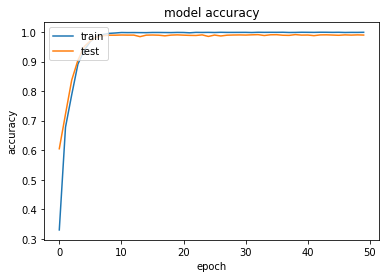

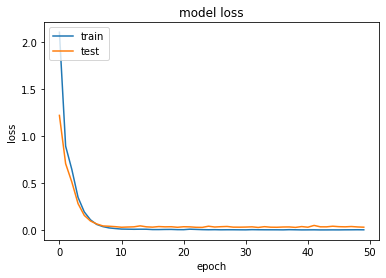

In [ ]:
# accuracy plot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()